## 1) Library & Data Import

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/yoonkt200/FastCampusDataset/master/tripadviser_review.csv")

In [3]:
df.head()

,rating,text
0,4,여행에 집중할수 있게 편안한 휴식을 제공하는 호텔이었습니다. 위치선정 또한 적당한 ...
1,4,"2일 이상 연박시 침대, 이불, 베게등 침구류 교체 및 어메니티 보강이 필요해 보입..."
2,4,지인에소개로온 호텔 깨끗하고 좋은거같아요 처음에는 없는게 많아 많이 당황했는데 ...
3,5,방에 딱 들어서자마자 눈이 휘둥그레질정도로 이렇게 넓은 호텔 처음 와본 것 같아요!...
4,5,저녁에 맥주한잔 하는게 좋아서 렌트 안하고 뚜벅이 하기로 했는데 호텔 바로 앞에 버...


#### Feature Description
- rating : 이용자 리뷰의 평가 점수
- text : 이용자 리뷰 평가 내용

-----

## 2) 데이터셋 살펴보기

### 2-1) 기본 정보 탐색

##### 데이터셋 기본 정보 탐색

In [4]:
df.shape

(1001, 2)

In [5]:
df.isnull().sum()

rating    0
text      0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001 entries, 0 to 1000
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   rating  1001 non-null   int64 
 1   text    1001 non-null   object
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


In [7]:
df['text'][0]

'여행에 집중할수 있게 편안한 휴식을 제공하는 호텔이었습니다. 위치선정 또한 적당한 편이었고 청소나 청결상태도 좋았습니다.'

In [8]:
len(df['text'].values.sum())

223576

-----

## 3) 한국어 텍스트 데이터 전처리

### 3-0) konlpy 설치

In [9]:
# 잘 안될 시, jpype1 Jpype1-py3 같이 설치
!pip install konlpy

### 3-1) 정규표현식 적용

In [10]:
import re

def apply_regular_expression(text):
    hangul = re.compile('[^ ㄱ-ㅣ가-힣]') # 한글의 정규표현식
    result = hangul.sub('', text)
    return result

In [11]:
apply_regular_expression(df['text'][0])

'여행에 집중할수 있게 편안한 휴식을 제공하는 호텔이었습니다 위치선정 또한 적당한 편이었고 청소나 청결상태도 좋았습니다'

-----

### 3-2) 한국어 형태소분석 - 명사 단위

##### 명사 형태소 추출

In [12]:
from konlpy.tag import Okt
from collections import Counter

nouns_tagger = Okt()
nouns = nouns_tagger.nouns(apply_regular_expression(df['text'][0]))

In [13]:
nouns

['여행', '집중', '휴식', '제공', '호텔', '위치', '선정', '또한', '청소', '청결', '상태']

In [14]:
# 전체 말뭉치(corpus)에서 명사 형태소 추출
nouns = nouns_tagger.nouns(apply_regular_expression("".join(df['text'].tolist())))

In [15]:
# 빈도 탐색
counter = Counter(nouns)
counter.most_common(10)

[('호텔', 803),
 ('수', 498),
 ('것', 436),
 ('방', 330),
 ('위치', 328),
 ('우리', 327),
 ('곳', 320),
 ('공항', 307),
 ('직원', 267),
 ('매우', 264)]

##### 한글자 명사 제거

In [16]:
available_counter = Counter({x : counter[x] for x in counter if len(x) > 1})
available_counter.most_common(10)

[('호텔', 803),
 ('위치', 328),
 ('우리', 327),
 ('공항', 307),
 ('직원', 267),
 ('매우', 264),
 ('가격', 245),
 ('객실', 244),
 ('시설', 215),
 ('제주', 192)]

-----

### 3-3) 불용어 사전

In [17]:
# source - https://www.ranks.nl/stopwords/korean
stopwords = pd.read_csv("https://raw.githubusercontent.com/yoonkt200/FastCampusDataset/master/korean_stopwords.txt").values.tolist()
print(stopwords[:10])

[['휴'], ['아이구'], ['아이쿠'], ['아이고'], ['어'], ['나'], ['우리'], ['저희'], ['따라'], ['의해']]


In [18]:
# 데이터 특징을 반영한 불용어 추가
jeju_hotel_stopwords = ['제주', '제주도', '호텔', '리뷰', '숙소', '여행', '트립']
for word in jeju_hotel_stopwords:
    stopwords.append(word)

-----

### 3-4) Word Count

##### BoW 벡터 생성

In [20]:
from sklearn.feature_extraction.text import CountVectorizer

def text_cleaning(text):
    hangul = re.compile('[^ ㄱ-ㅣ가-힣]')
    result = hangul.sub('', text)
    tagger = Okt()
    nouns = nouns_tagger.nouns(result)
    nouns = [x for x in nouns if len(x) > 1]
    nouns = [x for x in nouns if x not in stopwords]
    return nouns

vect = CountVectorizer(tokenizer = lambda x: text_cleaning(x))
bow_vect = vect.fit_transform(df['text'].tolist())
word_list = vect.get_feature_names_out()
count_list = bow_vect.toarray().sum(axis=0)

In [21]:
word_list

array(['가가', '가게', '가격', ..., '희망', '히터', '힐링'], dtype=object)

In [22]:
count_list

array([  4,   8, 245, ...,   1,   7,  14])

In [23]:
bow_vect.shape

(1001, 3599)

In [24]:
bow_vect.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 2, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [25]:
bow_vect.toarray().sum(axis=0)

array([  4,   8, 245, ...,   1,   7,  14])

In [26]:
bow_vect.toarray().sum(axis=0).shape

(3599,)

In [28]:
word_count_dict = dict(zip(word_list, count_list))
word_count_dict

-----

### 3-5) TF-IDF 적용

##### TF-IDF 변환

In [29]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_vectorizer = TfidfTransformer()
tf_idf_vect = tfidf_vectorizer.fit_transform(bow_vect)

In [30]:
print(tf_idf_vect.shape)
print(tf_idf_vect[0])

(1001, 3599)
  (0, 3588)	0.35673213299026796
  (0, 2927)	0.2582351368959594
  (0, 2925)	0.320251680858207
  (0, 2866)	0.48843555212083145
  (0, 2696)	0.23004450213863206
  (0, 2311)	0.15421663035331626
  (0, 1584)	0.48843555212083145
  (0, 1527)	0.2928089229786031
  (0, 790)	0.2528176728459411


##### 벡터 : 단어 맵핑

In [31]:
invert_index_vectorizer = {v: k for k, v in vect.vocabulary_.items()}
print(str(invert_index_vectorizer)[:100]+'..')

{2866: '집중', 3588: '휴식', 2696: '제공', 2311: '위치', 1584: '선정', 790: '또한', 2927: '청소', 2925: '청결', 1527..


-----

## 4) Logistic Regression 분류

### 4-1) 데이터셋 생성

##### Rating 데이터 이진으로 변환

In [32]:
df.head()

,rating,text
0,4,여행에 집중할수 있게 편안한 휴식을 제공하는 호텔이었습니다. 위치선정 또한 적당한 ...
1,4,"2일 이상 연박시 침대, 이불, 베게등 침구류 교체 및 어메니티 보강이 필요해 보입..."
2,4,지인에소개로온 호텔 깨끗하고 좋은거같아요 처음에는 없는게 많아 많이 당황했는데 ...
3,5,방에 딱 들어서자마자 눈이 휘둥그레질정도로 이렇게 넓은 호텔 처음 와본 것 같아요!...
4,5,저녁에 맥주한잔 하는게 좋아서 렌트 안하고 뚜벅이 하기로 했는데 호텔 바로 앞에 버...


<Axes: >

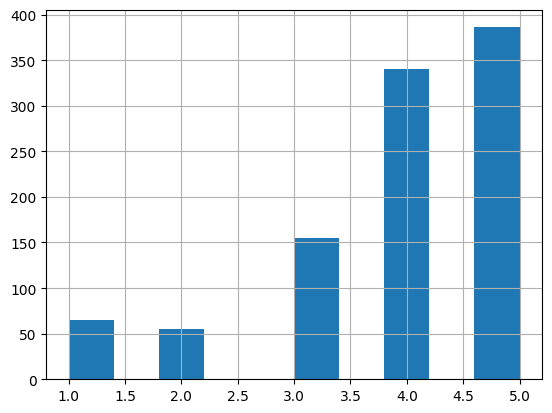

In [33]:
df.rating.hist()

In [34]:
def rating_to_label(rating):
    if rating > 3:
        return 1
    else:
        return 0

df['y'] = df['rating'].apply(lambda x: rating_to_label(x))

In [35]:
df.head()

,rating,text,y
0,4,여행에 집중할수 있게 편안한 휴식을 제공하는 호텔이었습니다. 위치선정 또한 적당한 ...,1
1,4,"2일 이상 연박시 침대, 이불, 베게등 침구류 교체 및 어메니티 보강이 필요해 보입...",1
2,4,지인에소개로온 호텔 깨끗하고 좋은거같아요 처음에는 없는게 많아 많이 당황했는데 ...,1
3,5,방에 딱 들어서자마자 눈이 휘둥그레질정도로 이렇게 넓은 호텔 처음 와본 것 같아요!...,1
4,5,저녁에 맥주한잔 하는게 좋아서 렌트 안하고 뚜벅이 하기로 했는데 호텔 바로 앞에 버...,1


In [36]:
df.y.value_counts()

y
1    726
0    275
Name: count, dtype: int64

-----

### 4-2) 데이터셋 분리

In [37]:
from sklearn.model_selection import train_test_split

y = df['y']
x_train, x_test, y_train, y_test = train_test_split(tf_idf_vect, y, test_size=0.30)

In [38]:
print(x_train.shape)
print(x_test.shape)

(700, 3599)
(301, 3599)


-----

### 4-3) 모델 학습

##### Logistic Regression 학습

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Train LR model
lr = LogisticRegression(random_state=0)
lr.fit(x_train, y_train)

# classifiacation predict
y_pred = lr.predict(x_test)

##### 분류 결과 평가

In [40]:
# classification result for test dataset
print("accuracy: %.2f" % accuracy_score(y_test, y_pred))
print("Precision : %.3f" % precision_score(y_test, y_pred))
print("Recall : %.3f" % recall_score(y_test, y_pred))
print("F1 : %.3f" % f1_score(y_test, y_pred))

accuracy: 0.74
Precision : 0.742
Recall : 1.000
F1 : 0.852


In [41]:
from sklearn.metrics import confusion_matrix

# print confusion matrix
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[  3  77]
 [  0 221]]


-----

### 4-4) 샘플링 재조정

##### 1:1 Sampling

In [42]:
positive_random_idx = df[df['y']==1].sample(275, random_state=33).index.tolist()
negative_random_idx = df[df['y']==0].sample(275, random_state=33).index.tolist()

In [43]:
# dataset split to train/test
random_idx = positive_random_idx + negative_random_idx
X = tf_idf_vect[random_idx]
y = df['y'][random_idx]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=33)

In [44]:
print(x_train.shape)
print(x_test.shape)

(412, 3599)
(138, 3599)


##### 모델 재학습

In [45]:
lr = LogisticRegression(random_state=0)
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)

##### 분류 결과 평가

In [46]:
print("accuracy: %.2f" % accuracy_score(y_test, y_pred))
print("Precision : %.3f" % precision_score(y_test, y_pred))
print("Recall : %.3f" % recall_score(y_test, y_pred))
print("F1 : %.3f" % f1_score(y_test, y_pred))

accuracy: 0.72
Precision : 0.644
Recall : 0.797
F1 : 0.712


In [47]:
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[53 26]
 [12 47]]


-----

## 5) 긍정/부정 키워드 분석

##### Logistic Regression 모델의 coef 분석

<BarContainer object of 3599 artists>

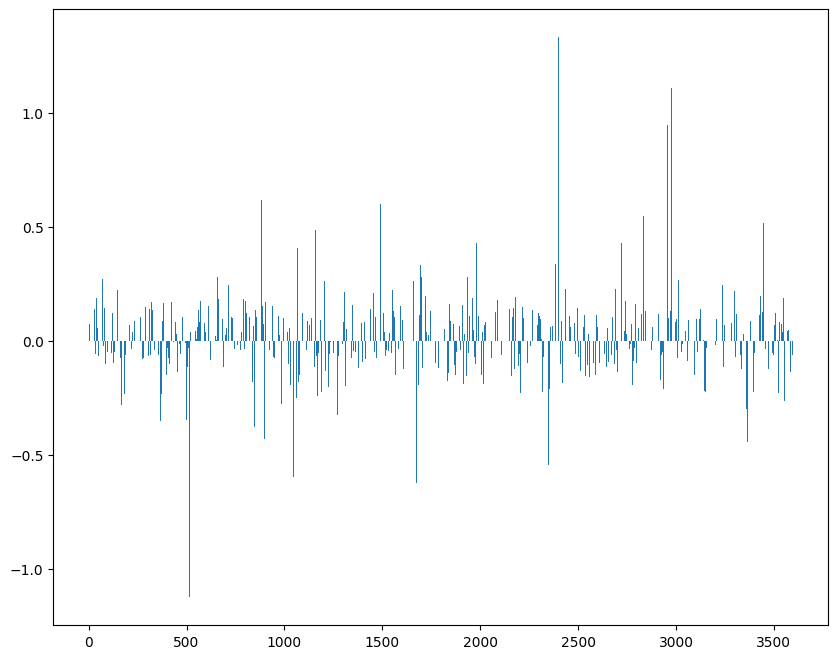

In [48]:
# print logistic regression's coef
plt.rcParams['figure.figsize'] = [10, 8]
plt.bar(range(len(lr.coef_[0])), lr.coef_[0])

##### 긍정/부정 키워드 출력

In [49]:
print(sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=True)[:5])
print(sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=True)[-5:])

[(1.3321308087111166, 2400), (1.1098677278465363, 2977), (1.029120247844704, 1247), (0.9474432432978867, 2957), (0.9049132254229897, 26)]
[(-0.6491883332225628, 363), (-0.6683241824194208, 3538), (-0.6811855513119685, 1909), (-0.9632209931825515, 1293), (-1.1245008869879287, 515)]


In [50]:
coef_pos_index = sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=True)
coef_neg_index = sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=False)
coef_pos_index

[(1.3321308087111166, 2400),
 (1.1098677278465363, 2977),
 (1.029120247844704, 1247),
 (0.9474432432978867, 2957),
 (0.9049132254229897, 26),
 (0.8631251640260484, 385),
 (0.8624237330200113, 2730),
 (0.7848182816732695, 578),
 (0.7329902190264134, 2311),
 (0.7168654931407249, 246),
 (0.7161355390234534, 1809),
 (0.7134163462461057, 956),
 (0.7044600617626677, 115),
 (0.6869152801231841, 1384),
 (0.6556108465327282, 1148),
 (0.6279495890384097, 2849),
 (0.6222266165132151, 2779),
 (0.6161464320403829, 883),
 (0.5993549427526994, 1491),
 (0.5957963623120055, 2680),
 (0.5486926383676383, 2834),
 (0.5396380473836403, 660),
 (0.5293505033175994, 416),
 (0.5268251635528765, 680),
 (0.5162996339456436, 3447),
 (0.515397298688398, 2781),
 (0.5102891400815143, 790),
 (0.5001491197806007, 3428),
 (0.4929472812035705, 1816),
 (0.4914445624836439, 692),
 (0.48756380000669713, 131),
 (0.48684210942709405, 1159),
 (0.45674587837763264, 1217),
 (0.45540907417568605, 1853),
 (0.45393688929077824, 981

In [51]:
invert_index_vectorizer = {v: k for k, v in vect.vocabulary_.items()}

In [52]:
for coef in coef_pos_index[:15]:
    print(invert_index_vectorizer[coef[1]], coef[0])

이용 1.3321308087111166
추천 1.1098677278465363
버스 1.029120247844704
최고 0.9474432432978867
가성 0.9049132254229897
근처 0.8631251640260484
조식 0.8624237330200113
다음 0.7848182816732695
위치 0.7329902190264134
공간 0.7168654931407249
시설 0.7161355390234534
맛집 0.7134163462461057
거리 0.7044600617626677
분위기 0.6869152801231841
바다 0.6556108465327282


In [53]:
for coef in coef_neg_index[:15]:
    print(invert_index_vectorizer[coef[1]], coef[0])

냄새 -1.1245008869879287
별로 -0.9632209931825515
아무 -0.6811855513119685
화장실 -0.6683241824194208
그냥 -0.6491883332225628
모기 -0.6302873381425532
수건 -0.6243491941007028
느낌 -0.5975494080979522
모텔 -0.5971174361320485
다른 -0.5966138818945081
최악 -0.593317479621261
음식 -0.5443424935120069
주위 -0.5321043465183405
진짜 -0.5254380815734119
목욕 -0.5087212885846033
